<a href="https://colab.research.google.com/github/DiploDatos/AprendizajeProfundo/blob/add_2024_content/6_CNN_para_clasificacion_de_imagenes_con_Pytorch_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN para clasificación de imágenes con Pytorch

- Veremos cómo construir una CNN para clasificar imágenes en MNIST.

- También tocaremos un poco cómo trabajar con modelos preentrenados (Tranfer Learning) como el modelo de [ResNet](https://pytorch.org/vision/stable/models.html#resnet).

In [ ]:
# Importando líbrerias
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import torch
from torch.utils.data import TensorDataset, DataLoader, SubsetRandomSampler, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor, transforms

seed = 28
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# Barajar los indices
indices = np.arange(60000)
np.random.shuffle(indices)
n_train = 55000

# Transformar los datos en tensores y normalícelos
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# Preparar el conjunto de entrenamiento y el conjunto de validación
dataset = datasets.MNIST('.', download=True, train=True, transform=transform)

# Construir el cargador de entranamiento
train_loader = DataLoader(dataset,
                            batch_size=64, shuffle=False,
                            sampler=SubsetRandomSampler(indices[:n_train])
                            )

# Construir el cargador de validación
val_loader = DataLoader(dataset,
                            batch_size=64, shuffle=False,
                            sampler=SubsetRandomSampler(indices[n_train:])
                            )

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 37215372.16it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1065004.08it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 9595542.63it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 7386788.98it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
len(train_loader), len(val_loader)

(860, 79)

In [ ]:
dataset[0][0].shape, dataset[0][1]

(torch.Size([1, 28, 28]), 5)

In [ ]:
train_loader.batch_size, val_loader.batch_size

(64, 64)

In [ ]:
def train_val(model, criterion, optimizer, train_loader, val_loader, num_epochs):
    # Ciclo for para el número de épocas
    train_loss_history, train_acc_history, val_loss_history, val_acc_history = [], [], [], []
    all_labels, all_preds = [], []
    model = model.to(device=device)
    for epoch in range(num_epochs):
        train_loss, train_acc, val_loss, val_acc = 0, 0, 0, 0

        # Establecer el modelo en modo de entrenamiento
        model.train()
        y_true_train, y_pred_train = [], []
        # Iterar sobre los datos de entrenamiento
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.long)
            optimizer.zero_grad()
            predicted_outputs = model(inputs)
            # Calcular la pérdida
            loss = criterion(predicted_outputs, labels)
            loss.backward()
            optimizer.step()
            # Acumular la pérdida y la precisión
            train_loss += loss.item()
            # La etiqueta con mayor valor será nuestra predicción
            _, predicted = torch.max(predicted_outputs , 1)
            y_true_train.extend(labels.cpu().numpy())
            y_pred_train.extend(predicted.cpu().numpy())

        # Calcular la pérdida y precisión promedio del entrenamiento
        train_loss /= len(train_loader)
        train_loss_history.append(train_loss)
        train_acc = accuracy_score(y_true_train, y_pred_train)
        train_acc_history.append(train_acc)

        # set the model to evaluation mode
        model.eval()
        y_true_test, y_pred_test = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.long)
                # Run the forward pass
                predicted_outputs = model(inputs)
                # Compute loss
                loss = criterion(predicted_outputs, labels)
                # Accumulate the average loss of the mini-batch
                val_loss += loss.item()
                # The label with the highest value will be our prediction
                _, predicted = torch.max(predicted_outputs , 1)
                y_true_test.extend(labels.cpu().numpy())
                y_pred_test.extend(predicted.cpu().numpy())

        # calculate the average validation loss and accuracy
        val_loss /= len(val_loader)
        val_loss_history.append(val_loss)
        val_acc = accuracy_score(y_true_test, y_pred_test)
        val_acc_history.append(val_acc)
        all_labels.extend(y_true_test)
        all_preds.extend(y_pred_test)

        print(f'Epoch {epoch+1}/{num_epochs}, train loss: {train_loss:.4f}, train acc: {train_acc:.4f}, val loss: {val_loss:.4f}, val acc: {val_acc:.4f}')

    experiment = {
        'epoch_training_loss': train_loss_history,
        'training_accuracy': train_acc_history,
        'epoch_validation_loss': val_loss_history,
        'validation_accuracy': val_acc_history
    }
    experiment['epoch'] = list(range(num_epochs))

    return experiment, all_labels, all_preds


def plotting_confusion_matrix(all_labels, all_preds, title_name=''):

    # Plotting Confusion Matrix
    fig, axs = plt.subplots(1, 2, figsize = (14, 6))

    # Implementing visualization of Confusion Matrix
    c_m = confusion_matrix(all_labels, all_preds)
    c_m_normalized = confusion_matrix(all_labels, all_preds, normalize='true').round(3)

    ConfusionMatrixDisplay(c_m, display_labels=dataset.classes).plot(cmap='Greys', xticks_rotation=25, ax=axs[0])
    ConfusionMatrixDisplay(c_m_normalized*100, display_labels=dataset.classes).plot(cmap='Greys', xticks_rotation=25, ax=axs[1],)

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    axs[0].set_title('Valores absolutos', fontsize=14)
    axs[1].set_title('Valores porcentuales', fontsize=14)
    plt.suptitle(f'Confusion Matrix {title_name}', fontsize=16)
    plt.show()


def plot_loss_and_accuracy(train_loss_history, val_loss_history, train_acc_history, val_acc_history):
    fig, axs = plt.subplots(1, 2, figsize = (10, 4))

    # Plot the training and validation loss
    axs[0].plot(train_loss_history, label='train loss')
    axs[0].plot(val_loss_history, label='val loss')
    axs[0].grid()

    # Plot the training and validation accuracy
    axs[1].plot(train_acc_history, label='train acc')
    axs[1].plot(val_acc_history, label='val acc')
    axs[1].grid()
    plt.legend()
    plt.show()

import pandas as pd
import seaborn as sns

def plot_loss_and_accuracy(experiment, title=None):
  df_experiment = pd.DataFrame(experiment)

  fig, axs = plt.subplots(1, 2, figsize=(15, 4))
  sns.lineplot(data=df_experiment, x='epoch', y='epoch_training_loss', color='orange',
                  label='Training', markersize=10, lw=1.5, marker='*', ax=axs[0])
  sns.lineplot(data=df_experiment, x='epoch', y='epoch_validation_loss',
                  label='Validation', markersize=10, linestyle='--', lw=1.5, marker='.', ax=axs[0])
  plt.grid('--')
  sns.lineplot(data=df_experiment, x='epoch', y='training_accuracy', color='orange',
                  label='Training', markersize=10, lw=1.5, marker='*', ax=axs[1])
  sns.lineplot(data=df_experiment, x='epoch', y='validation_accuracy',
                  label='Validation', markersize=10, linestyle='--', lw=1.5, marker='.', ax=axs[1])
  for i, ax in enumerate(axs.ravel()):
      print(i)
      ax.set_xlabel('Epoch')
      if i < 1:
        ax.set_ylabel('Loss')
      else:
        ax.set_ylabel('Accuracy')
      ax.legend()
      ax.grid('--')
      ax.spines["top"].set_visible(False)
      ax.spines["right"].set_visible(False)
  plt.suptitle(title)
  plt.xticks(rotation=40, fontsize=8)
  plt.yticks(fontsize=9)
  plt.show()

## Modelo de clasificación con Capas Fully Connected

In [ ]:
# Define the class Net
class Net(nn.Module):
    def __init__(self, num_classes=10):
    	# Define all the parameters of the net
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28 * 1, 200)
        self.fc2 = nn.Linear(200, num_classes)

    def forward(self, x):
    	# Do the forward pass
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# Instantiate the Adam optimizer and Cross-Entropy loss function
model = Net()
optimizer = optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()

for batch_idx, (data, target) in enumerate(train_loader):
    data = data.view(-1, 28 * 28)
    optimizer.zero_grad()
    # Complete a forward pass
    output = model(data)
    # Compute the loss, gradients and change the weights
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()

# Set the model in eval mode
model.eval()
total, correct = (0, 0)
all_labels, all_preds = [], []
for i, data in enumerate(val_loader, 0):
    inputs, labels = data
    all_labels.extend(list(labels.numpy()))

    # Put each image into a vector
    inputs = inputs.view(-1, 28*28*1)

    # Do the forward pass and get the predictions
    outputs = model(inputs)
    _, outputs = torch.max(outputs.data, 1)
    all_preds.extend(list(outputs.numpy()))
    total += labels.size(0)
    correct += (outputs == labels).sum().item()
print('The testing set accuracy of the network is: %d %%' % (100 * correct / total))

The testing set accuracy of the network is: 93 %


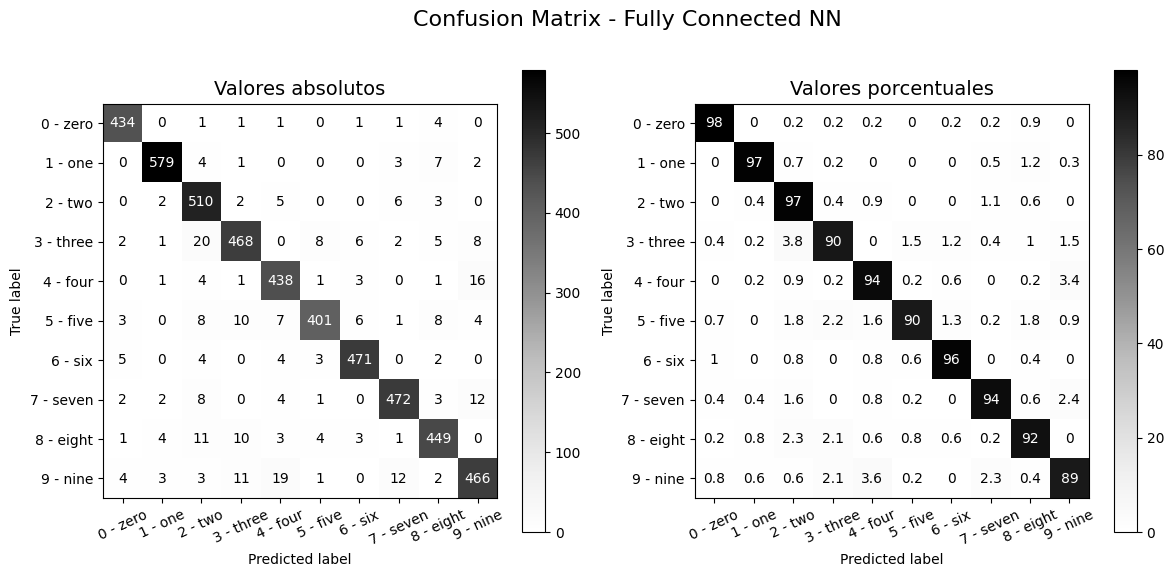

In [ ]:
plotting_confusion_matrix(all_labels, all_preds, title_name='- Fully Connected NN')

## **Arquitecturas Bases**

###**Capa Convolucional**

Una capa convolucional en una red neuronal convolucional (CNN) es el componente central responsable de extraer características de las entradas, típicamente imágenes o secuencias. Se llama "convolucional" porque utiliza la operación matemática de convolución, que permite que la red aprenda filtros que detectan patrones específicos en la entrada, como bordes, texturas, formas, u objetos completos, dependiendo de la profundidad de la red.

**¿Qué es la convolución?**
La convolución es una operación matemática que aplica un filtro (kernel) sobre cada canal de una imagen (o entrada). El filtro es una pequeña matriz de pesos que "se desliza" sobre la imagen, multiplicando los valores de los píxeles de la imagen por los valores del filtro en cada posición. El resultado es un mapa de características que resalta ciertos patrones en la imagen original.

**Elementos de la capa convolucional:**
- Filtro (kernel): La capa convolucional utiliza un conjunto de filtros o kernels, que son matrices pequeñas (típicamente de tamaño 3x3, 5x5, etc.) que se entrenan para detectar características específicas.
- Stride: El stride es el paso con el que el filtro se desplaza sobre la imagen. Un stride mayor significa que el filtro se mueve más rápido por la imagen, produciendo una salida de menor tamaño.
- Padding: A veces se añaden ceros alrededor de los bordes de la imagen (llamado padding) para asegurarse de que el tamaño de la salida sea el mismo que el de la entrada, o para evitar que se pierda información en los bordes.

**Activación:** después de la convolución, se aplica una función de activación no lineal (generalmente ReLU), que introduce no linealidad en el modelo para que la red pueda aprender representaciones complejas.

**Parámetros de una capa convolucional:**
- in_channels: número de canales en la entrada (por ejemplo, 3 para imágenes RGB).
- out_channels: número de filtros que se utilizarán, y por lo tanto, el número de canales en la salida.
- kernel_size: tamaño del filtro o kernel (ej. 3x3).
- stride: tamaño del paso con el que el filtro se desplaza sobre la entrada.
- padding: ceros agregados alrededor de la imagen para controlar el tamaño de la salida.

### **Capa Pooling**

Mediante la capa pooling logramos:
- Reducción de dimensionalidad: logra que el modelo sea más eficiente computacionalmente.
- Control del sobreajuste: ayuda a evitar el sobreajuste reduciendo el número de parámetros.
- Extracción de características robustas: las capas de pooling ayudan a preservar las características importantes.
- Invarianza a la traducción: aumenta la capacidad de la red para reconocer patrones en diferentes ubicaciones.

In [ ]:
class NetCNN(nn.Module):
    def __init__(self):
        super(NetCNN, self).__init__()
        # Instantiate two convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=5, out_channels=10, kernel_size=3, padding=1)
        # Instantiate the ReLU nonlinearity
        self.relu = nn.ReLU()
        # Instantiate a max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # Instantiate a fully connected layer
        self.fc = nn.Linear(7 * 7 * 10, 10)


    def forward(self, x):
        # Apply conv followd by relu, then in next line pool
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        # Apply conv followed by relu, then in next line pool
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        # Prepare the image for the fully connected layer
        x = x.view(-1, self.fc.in_features)
        # Apply the fully connected layer and return the result
        return self.fc(x)

In [ ]:
class NetCNNwithoutPadding(nn.Module):
    def __init__(self):
        super(NetCNNwithoutPadding, self).__init__()
        # Instantiate two convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5, padding=0)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5, padding=0)
        # Instantiate the ReLU nonlinearity
        self.relu = nn.ReLU()
        # Instantiate a max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # Instantiate a fully connected layer
        self.fc = nn.Linear(4 * 4 * 20, 10)


    def forward(self, x):
        # Apply conv followd by relu, then in next line pool
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        # Apply conv followd by relu, then in next line pool
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        # Prepare the image for the fully connected layer
        x = x.view(-1, self.fc.in_features)
        # Apply the fully connected layer and return the result
        return self.fc(x)

## Entrenar Net without Padding

In [ ]:
num_epochs = 30
# Instantiate the network
model = NetCNNwithoutPadding()
# Instantiate the cross-entropy loss
criterion = nn.CrossEntropyLoss()
# Instantiate the SGD optimizer
optimizer = optim.SGD(model.parameters(), lr=1e-2, weight_decay=0.001, momentum=0.9)
experiment, all_labels, all_preds = train_val(model, criterion, optimizer, train_loader, val_loader, num_epochs)

Epoch 1/30, train loss: 0.1886, train acc: 0.9421, val loss: 0.0705, val acc: 0.9776
Epoch 2/30, train loss: 0.0585, train acc: 0.9819, val loss: 0.0592, val acc: 0.9828
Epoch 3/30, train loss: 0.0452, train acc: 0.9856, val loss: 0.0514, val acc: 0.9842
Epoch 4/30, train loss: 0.0371, train acc: 0.9886, val loss: 0.0510, val acc: 0.9842
Epoch 5/30, train loss: 0.0339, train acc: 0.9893, val loss: 0.0437, val acc: 0.9874
Epoch 6/30, train loss: 0.0297, train acc: 0.9909, val loss: 0.0510, val acc: 0.9852
Epoch 7/30, train loss: 0.0286, train acc: 0.9909, val loss: 0.0491, val acc: 0.9862
Epoch 8/30, train loss: 0.0261, train acc: 0.9921, val loss: 0.0402, val acc: 0.9872
Epoch 9/30, train loss: 0.0246, train acc: 0.9924, val loss: 0.0424, val acc: 0.9868
Epoch 10/30, train loss: 0.0229, train acc: 0.9928, val loss: 0.0374, val acc: 0.9900
Epoch 11/30, train loss: 0.0212, train acc: 0.9933, val loss: 0.0419, val acc: 0.9876
Epoch 12/30, train loss: 0.0217, train acc: 0.9932, val loss: 0

0
1


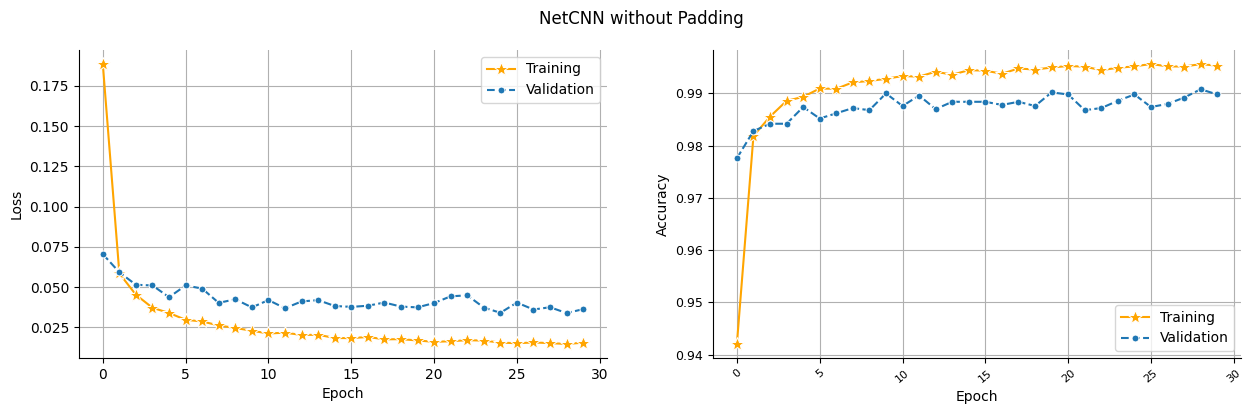

In [ ]:
plot_loss_and_accuracy(experiment, title='NetCNN without Padding')

In [ ]:
params = model.state_dict()

# Dimensiones de las capas
print('Dimensiones de las capas:')
for name, param in model.named_parameters():
    print(f'\t{name}: {param.shape}')

# Cantidad de parámetros
print('Cantidad de parámetros:')
for key, value in params.items():
    print(f'\t{key}: {torch.numel(value)}')

print(f'Modelo: {model}')

Dimensiones de las capas:
	conv1.weight: torch.Size([10, 1, 5, 5])
	conv1.bias: torch.Size([10])
	conv2.weight: torch.Size([20, 10, 5, 5])
	conv2.bias: torch.Size([20])
	fc.weight: torch.Size([10, 320])
	fc.bias: torch.Size([10])
Cantidad de parámetros:
	conv1.weight: 250
	conv1.bias: 10
	conv2.weight: 5000
	conv2.bias: 20
	fc.weight: 3200
	fc.bias: 10
Modelo: NetCNNwithoutPadding(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=320, out_features=10, bias=True)
)


## Entrenar NetCNN

In [ ]:
num_epochs = 30
model = NetCNN()
optimizer = optim.SGD(model.parameters(), lr=1e-2, weight_decay=0.001, momentum=0.9)

experiment, all_labels, all_preds = train_val(model, criterion, optimizer, train_loader, val_loader, num_epochs)

Epoch 1/30, train loss: 0.2546, train acc: 0.9214, val loss: 0.1030, val acc: 0.9682
Epoch 2/30, train loss: 0.0859, train acc: 0.9735, val loss: 0.0742, val acc: 0.9802
Epoch 3/30, train loss: 0.0667, train acc: 0.9792, val loss: 0.0673, val acc: 0.9802
Epoch 4/30, train loss: 0.0585, train acc: 0.9817, val loss: 0.0620, val acc: 0.9824
Epoch 5/30, train loss: 0.0536, train acc: 0.9836, val loss: 0.0610, val acc: 0.9818
Epoch 6/30, train loss: 0.0511, train acc: 0.9836, val loss: 0.0660, val acc: 0.9786
Epoch 7/30, train loss: 0.0473, train acc: 0.9851, val loss: 0.0628, val acc: 0.9808
Epoch 8/30, train loss: 0.0444, train acc: 0.9859, val loss: 0.0641, val acc: 0.9804
Epoch 9/30, train loss: 0.0428, train acc: 0.9866, val loss: 0.0564, val acc: 0.9830
Epoch 10/30, train loss: 0.0413, train acc: 0.9869, val loss: 0.0581, val acc: 0.9826
Epoch 11/30, train loss: 0.0401, train acc: 0.9871, val loss: 0.0617, val acc: 0.9836
Epoch 12/30, train loss: 0.0389, train acc: 0.9878, val loss: 0

0
1


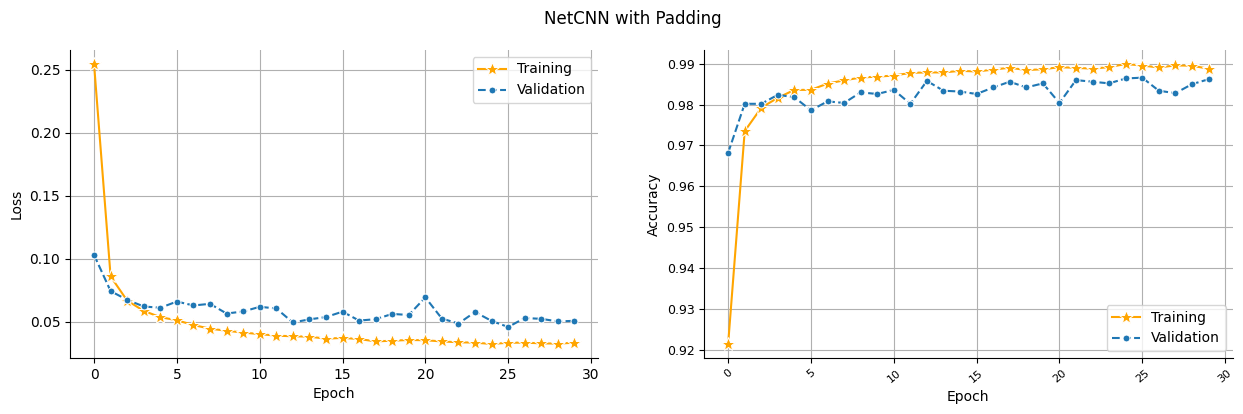

In [ ]:
plot_loss_and_accuracy(experiment, title='NetCNN with Padding')

Se observa en el gráfico un ligero overfiiting.

In [ ]:
params = model.state_dict()

# Dimensiones de las capas
print('Dimensiones de las capas:')
for name, param in model.named_parameters():
    print(f'\t{name}: {param.shape}')

# Cantidad de parámetros
print('Cantidad de parámetros:')
for key, value in params.items():
    print(f'\t{key}: {torch.numel(value)}')

print(f'Modelo: {model}')

Dimensiones de las capas:
	conv1.weight: torch.Size([5, 1, 3, 3])
	conv1.bias: torch.Size([5])
	conv2.weight: torch.Size([10, 5, 3, 3])
	conv2.bias: torch.Size([10])
	fc.weight: torch.Size([10, 490])
	fc.bias: torch.Size([10])
Cantidad de parámetros:
	conv1.weight: 45
	conv1.bias: 5
	conv2.weight: 450
	conv2.bias: 10
	fc.weight: 4900
	fc.bias: 10
Modelo: NetCNN(
  (conv1): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=490, out_features=10, bias=True)
)


## Modificar el modelo

In [ ]:
# Change the number of out channels
model = NetCNN()

model.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5, padding=0)
model.conv2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, padding=0)
model.fc = nn.Linear(5 * 5 * 8, 10)

optimizer = optim.SGD(model.parameters(), lr=1e-2, weight_decay=0.001, momentum=0.9)

experiment, all_labels, all_preds = train_val(model, criterion, optimizer, train_loader, val_loader, 30)

Epoch 1/30, train loss: 0.2344, train acc: 0.9274, val loss: 0.1041, val acc: 0.9700
Epoch 2/30, train loss: 0.0796, train acc: 0.9761, val loss: 0.0693, val acc: 0.9814
Epoch 3/30, train loss: 0.0656, train acc: 0.9799, val loss: 0.0657, val acc: 0.9802
Epoch 4/30, train loss: 0.0581, train acc: 0.9820, val loss: 0.0687, val acc: 0.9792
Epoch 5/30, train loss: 0.0547, train acc: 0.9833, val loss: 0.0593, val acc: 0.9834
Epoch 6/30, train loss: 0.0518, train acc: 0.9836, val loss: 0.0653, val acc: 0.9808
Epoch 7/30, train loss: 0.0487, train acc: 0.9850, val loss: 0.0525, val acc: 0.9832
Epoch 8/30, train loss: 0.0477, train acc: 0.9851, val loss: 0.0622, val acc: 0.9824
Epoch 9/30, train loss: 0.0473, train acc: 0.9847, val loss: 0.0535, val acc: 0.9856
Epoch 10/30, train loss: 0.0452, train acc: 0.9859, val loss: 0.0548, val acc: 0.9836
Epoch 11/30, train loss: 0.0451, train acc: 0.9857, val loss: 0.0531, val acc: 0.9842
Epoch 12/30, train loss: 0.0435, train acc: 0.9863, val loss: 0

0
1


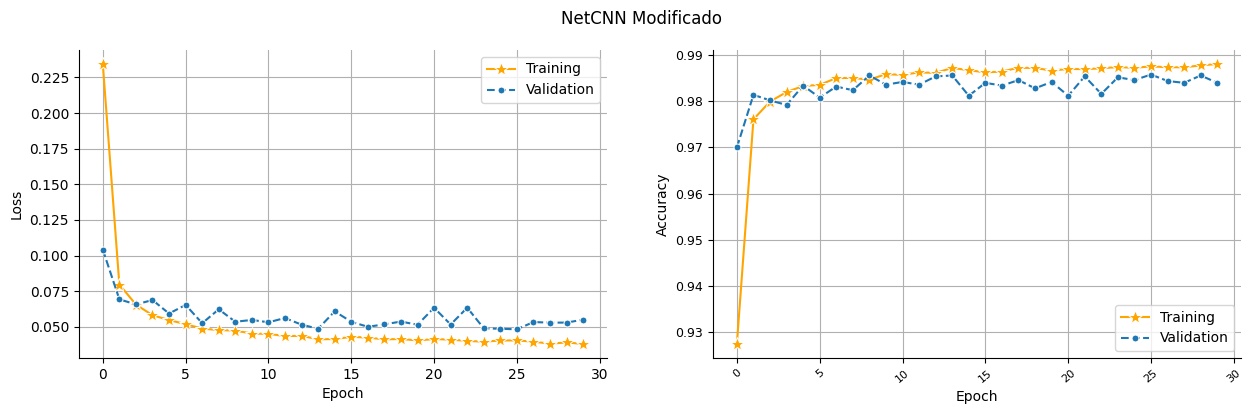

In [ ]:
plot_loss_and_accuracy(experiment, title='NetCNN Modificado')

Al disminuir la cantidad de kernels, logramos reducir un poco más el overfitting.

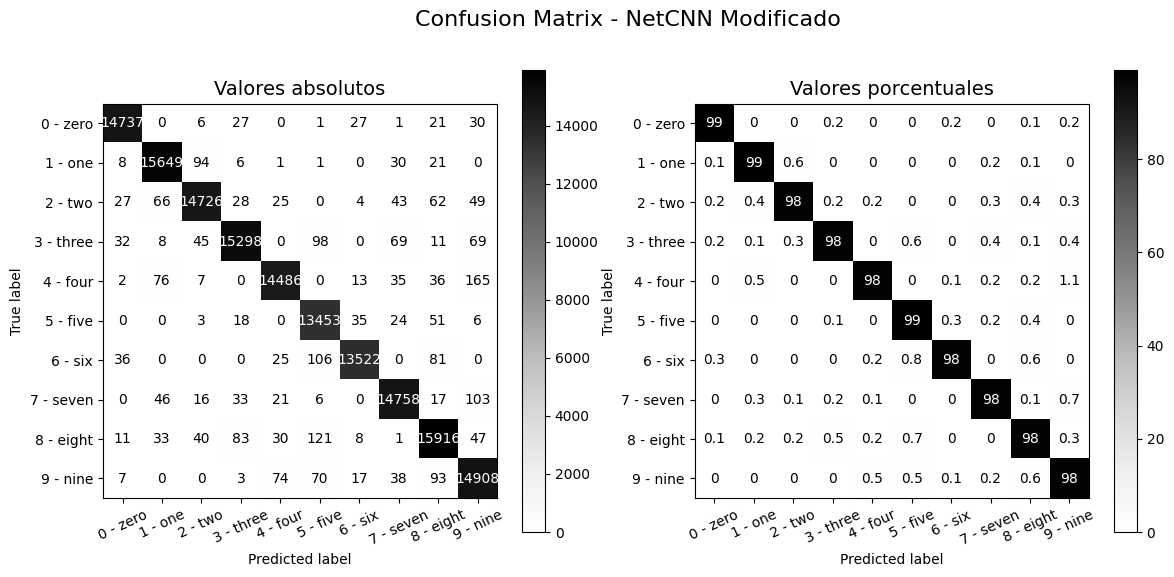

In [ ]:
plotting_confusion_matrix(all_labels, all_preds, title_name='- NetCNN Modificado')

In [ ]:
# Otra manera de cambiar los parámetros de la red
setattr(model, 'conv1', nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5, padding=0))
setattr(model, 'conv2', nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, padding=0))
setattr(model, 'fc', nn.Linear(5 * 5 * 8, 10))
print(f'Modelo: {model}')

Modelo: NetCNN(
  (conv1): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=200, out_features=10, bias=True)
)


## Ejemplo de Otra Arquitectura con Batch Normalization

### 🤷 **¿Aplicar batch normalization antes o después del pooling?** 🤯

In [ ]:
# Model with batch normalization applied after pooling
class NetCNNwithBN_v1(nn.Module):
    def __init__(self):
        super(NetCNNwithBN_v1, self).__init__()

        # Implement the sequential module for feature extraction
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(10),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(20),
            nn.ReLU(inplace=True),
            )

        # Implement the fully connected layer for classification
        self.fc = nn.Linear(in_features=7 * 7 * 20, out_features=10)

    def forward(self, x):

        # Apply the feature extractor in the input
        x = self.features(x)

        # Squeeze the three spatial dimensions in one
        x = x.view(-1, self.fc.in_features)

        # Classify the images
        x = self.fc(x)
        return x

In [ ]:
# Entrenamiento con optimizador Adam
model = NetCNNwithBN_v1()
optimizer = optim.SGD(model.parameters(), lr=1e-2, weight_decay=0.001, momentum=0.9)
experiment, all_labels, all_preds = train_val(model, criterion, optimizer, train_loader, val_loader, num_epochs)

Epoch 1/30, train loss: 0.1246, train acc: 0.9623, val loss: 0.0617, val acc: 0.9824
Epoch 2/30, train loss: 0.0511, train acc: 0.9850, val loss: 0.0468, val acc: 0.9866
Epoch 3/30, train loss: 0.0414, train acc: 0.9879, val loss: 0.0514, val acc: 0.9846
Epoch 4/30, train loss: 0.0355, train acc: 0.9895, val loss: 0.0450, val acc: 0.9870
Epoch 5/30, train loss: 0.0323, train acc: 0.9906, val loss: 0.0430, val acc: 0.9868
Epoch 6/30, train loss: 0.0301, train acc: 0.9919, val loss: 0.0416, val acc: 0.9870
Epoch 7/30, train loss: 0.0280, train acc: 0.9922, val loss: 0.0482, val acc: 0.9852
Epoch 8/30, train loss: 0.0264, train acc: 0.9929, val loss: 0.0438, val acc: 0.9860
Epoch 9/30, train loss: 0.0248, train acc: 0.9935, val loss: 0.0450, val acc: 0.9868
Epoch 10/30, train loss: 0.0242, train acc: 0.9934, val loss: 0.0437, val acc: 0.9878
Epoch 11/30, train loss: 0.0231, train acc: 0.9936, val loss: 0.0385, val acc: 0.9888
Epoch 12/30, train loss: 0.0226, train acc: 0.9941, val loss: 0

0
1


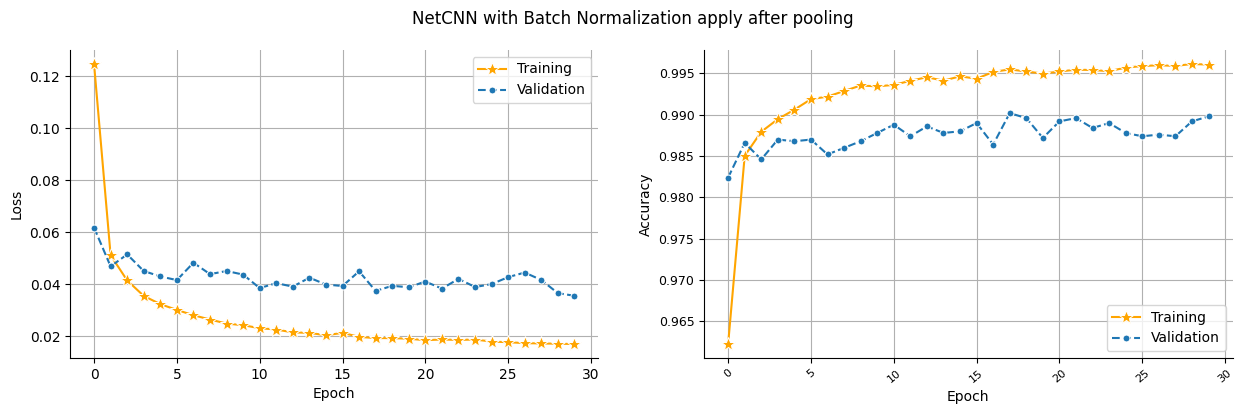

In [ ]:
plot_loss_and_accuracy(experiment, title='NetCNN with Batch Normalization apply after pooling')

In [ ]:
# Model with batch normalization applied before pooling
class NetCNNwithBN_v2(nn.Module):
    def __init__(self):
        super(NetCNNwithBN_v2, self).__init__()

        # Implement the sequential module for feature extraction
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(10),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(20),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )

        # Implement the fully connected layer for classification
        self.fc = nn.Linear(in_features=7 * 7 * 20, out_features=10)

    def forward(self, x):

        # Apply the feature extractor in the input
        x = self.features(x)

        # Squeeze the three spatial dimensions in one
        x = x.view(-1, self.fc.in_features)

        # Classify the images
        x = self.fc(x)
        return x

In [ ]:
# Entrenamiento con optimizador SGD con momentum
model = NetCNNwithBN_v2()
optimizer = optim.SGD(model.parameters(), lr=1e-2, weight_decay=0.001, momentum=0.9)
experiment, all_labels, all_preds = train_val(model, criterion, optimizer, train_loader, val_loader, num_epochs)

Epoch 1/30, train loss: 0.1420, train acc: 0.9554, val loss: 0.0609, val acc: 0.9800
Epoch 2/30, train loss: 0.0597, train acc: 0.9817, val loss: 0.0485, val acc: 0.9858
Epoch 3/30, train loss: 0.0475, train acc: 0.9855, val loss: 0.0595, val acc: 0.9808
Epoch 4/30, train loss: 0.0421, train acc: 0.9873, val loss: 0.0505, val acc: 0.9854
Epoch 5/30, train loss: 0.0384, train acc: 0.9888, val loss: 0.0449, val acc: 0.9864
Epoch 6/30, train loss: 0.0352, train acc: 0.9896, val loss: 0.0503, val acc: 0.9852
Epoch 7/30, train loss: 0.0317, train acc: 0.9905, val loss: 0.0471, val acc: 0.9868
Epoch 8/30, train loss: 0.0316, train acc: 0.9908, val loss: 0.0502, val acc: 0.9870
Epoch 9/30, train loss: 0.0310, train acc: 0.9912, val loss: 0.0382, val acc: 0.9884
Epoch 10/30, train loss: 0.0291, train acc: 0.9912, val loss: 0.0494, val acc: 0.9850
Epoch 11/30, train loss: 0.0276, train acc: 0.9917, val loss: 0.0411, val acc: 0.9862
Epoch 12/30, train loss: 0.0277, train acc: 0.9914, val loss: 0

0
1


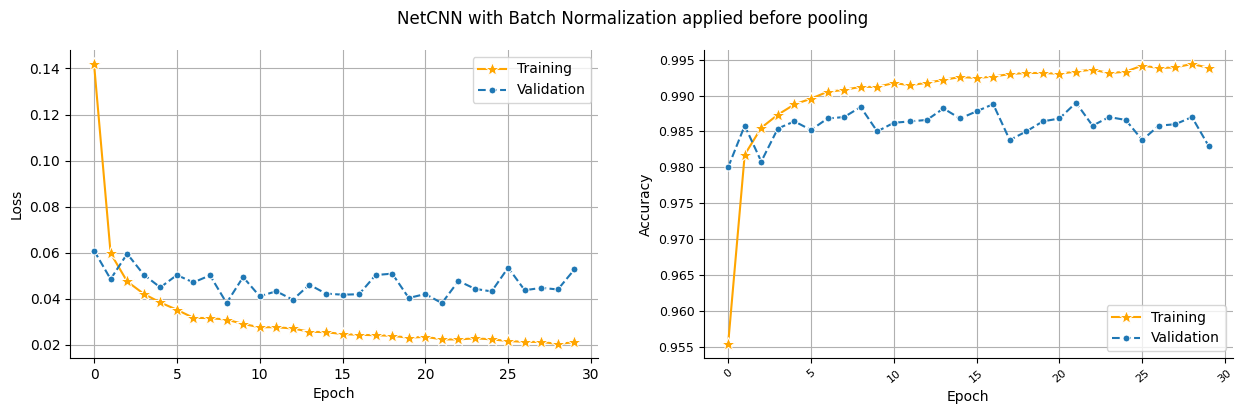

In [ ]:
plot_loss_and_accuracy(experiment, title='NetCNN with Batch Normalization applied before pooling')

**¿Aplicar batch normalization antes o después de la función de activación?**

Se sugiere:
- Con función de activación ReLU --> aplicar antes
- Con función de activación sigmoides (tanh y logística) --> aplicar después

En general, funciona mejor aplicar batch normalization antes de la función de activación.

Sin embargo, siempre es bueno probar ambos ordenes para ver qué funciona mejor.

In [ ]:
# Probar aplicar batch normalization después de la activación ReLU (Concluir)




## Transfer Learning

Probaremos los modelos ResNet18 (o cualquier variante de la familia ResNet, como ResNet-18, ResNet-34, ResNet-50, etc.) y VGG16.
Tanto ResNet como VGG fueron entrenados en el mismo conjunto de datos, ImageNet, lo que los convierte en modelos extremadamente útiles para transfer learning en muchas otras tareas de visión por computadora. ResNet es particularmente popular debido a su capacidad para entrenar redes más profundas sin perder rendimiento, gracias a su uso de bloques residuales.

**Detalles de ImageNet**
- Cantidad de imágenes: Más de 14 millones de imágenes.
- Cantidad de categorías: 1,000 clases diferentes, que incluyen una amplia gama de objetos cotidianos.
    - Animales: perros, gatos, aves, peces, etc.
    - Objetos cotidianos: tazas, relojes, teclados, teléfonos.
    - Vehículos: coches, bicicletas, aviones, barcos.
    - Naturaleza: árboles, flores, frutas.
    - Personas y sus partes: caras, manos, pies.
- Resolución de las imágenes: Las imágenes de ImageNet tienen una resolución variada, pero en la mayoría de los modelos preentrenados, las imágenes son redimensionadas a 224x224 píxeles para su procesamiento.

### **Buenas prácticas**
- Congelar capas convolucionales: Congelar las capas convolucionales al principio y solo entrenar las últimas capas (las capas densas) puede ser útil, ya que las primeras capas han aprendido características generales que son útiles para muchas tareas.
- Descongelar capas para ajuste fino: Después de entrenar las nuevas capas superiores, puedes descongelar algunas de las capas convolucionales para ajustar mejor la red a tu tarea específica. En este caso, un optimizador como SGD con momentum suele funcionar bien para evitar grandes cambios en los pesos preentrenados.
- Tasa de aprendizaje: Cuando haces ajuste fino, considera utilizar una tasa de aprendizaje más baja que en el entrenamiento inicial. Por ejemplo, si entrenas las capas nuevas con una tasa de aprendizaje de 1e-3, podrías reducirla a 1e-4 o 1e-5 cuando ajustas los pesos de las capas preentrenadas.

### Transfer Learning [Resnet18](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html)

Existen las arquitecturas ResNet-18, ResNet-34, y ResNet-50 son variantes de la red residual ResNet (Residual Network), y se diferencian principalmente en el número de capas y en cómo se estructuran los bloques residuales. Aquí te explico las principales diferencias entre ellas:

**Número de capas**

El número que sigue a "ResNet" indica cuántas capas tiene la red.
- ResNet-18: Tiene 18 capas convolucionales de aprendizaje.
- ResNet-34: Tiene 34 capas de aprendizaje.
- ResNet-50: Tiene 50 capas de aprendizaje.

El aumento en el número de capas permite que la red sea más profunda y, en teoría, más capaz de aprender representaciones más complejas. Sin embargo, esto también aumenta el costo computacional y el tiempo de entrenamiento.


**Estructura de los bloques residuales**

Los bloques residuales son la base de las arquitecturas ResNet. En un bloque residual, se agrega la entrada al resultado de varias capas convolucionales, permitiendo que los gradientes fluyan más fácilmente a través de redes muy profundas y evitando el problema del "vanishing gradient".
- ResNet-18 y ResNet-34 utilizan bloques residuales básicos:
  - Un bloque básico está compuesto por dos capas convolucionales con tamaños de filtro 3x3 y una conexión residual que suma la entrada del bloque al resultado final.
ResNet-50 utiliza bloques residuales con cuellos de botella ("bottleneck blocks"):

- Los bloques de cuello de botella consisten en tres capas en lugar de dos:
  - Una convolución 1x1 para reducir la dimensionalidad.
  - Una convolución 3x3 que actúa sobre la representación reducida.
  - Otra convolución 1x1 para restaurar la dimensionalidad original.

Esta estructura permite que la red ResNet-50 sea más profunda y eficiente, al reducir temporalmente la dimensionalidad dentro de los bloques.

**Comparación en términos de precisión y uso**
- En general, ResNet-50 logra una mayor precisión en tareas de clasificación y detección de objetos, ya que su mayor profundidad le permite aprender representaciones más sofisticadas.
- ResNet-18 y ResNet-34 siguen siendo competitivas en precisión, pero son más eficientes para problemas que no requieren una capacidad de representación tan compleja o cuando se busca un buen equilibrio entre precisión y costo computacional.

<center><img src="https://drive.google.com/uc?export=view&id=10C0IglAF1-UrcpeHjmYZbdjeHSAdShEy" width="400" alt="ResNet" title="Underfitting 2"/></center>

In [ ]:
batch_size = 64

# Transformar los datos en tensores y normalícelos
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# transform = transforms.Compose([transforms.ToTensor()])
transform = transforms.Compose([transforms.Resize(256),
              # Es importante adaptar el tamaño de nuestras imagenes al tamaño de las imágenes usadas para entrenar la red
              transforms.CenterCrop(224),
              transforms.ToTensor(),
              transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# Preparar el conjunto de entrenamiento y el conjunto de validación
trainset = datasets.CIFAR10('.', download=True, train=True, transform=transform)
validateset = datasets.CIFAR10('.', download=False, train=False, transform=transform)

# Construir el cargador de entranamiento
train_loader = DataLoader(trainset,
                            batch_size=batch_size, shuffle=True,
                            )

# Construir el cargador de validación
val_loader = DataLoader(validateset,
                            batch_size=batch_size, shuffle=False,
                            )

100%|██████████| 170498071/170498071 [00:13<00:00, 12849811.71it/s]


Extracting ./cifar-10-python.tar.gz to .


In [ ]:
# Cargar el modelo preentrenado
model_rn18 = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')  # pretrained=True fue deprecado
print(f'Modelo: {model_rn18}')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 50.3MB/s]

Modelo: ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=

In [ ]:
# Explorar las capas del modelo
for i, w in enumerate(model_rn18.parameters()):
    print(i+1, w.shape, w.requires_grad)

1 torch.Size([64, 3, 7, 7]) True
2 torch.Size([64]) True
3 torch.Size([64]) True
4 torch.Size([64, 64, 3, 3]) True
5 torch.Size([64]) True
6 torch.Size([64]) True
7 torch.Size([64, 64, 3, 3]) True
8 torch.Size([64]) True
9 torch.Size([64]) True
10 torch.Size([64, 64, 3, 3]) True
11 torch.Size([64]) True
12 torch.Size([64]) True
13 torch.Size([64, 64, 3, 3]) True
14 torch.Size([64]) True
15 torch.Size([64]) True
16 torch.Size([128, 64, 3, 3]) True
17 torch.Size([128]) True
18 torch.Size([128]) True
19 torch.Size([128, 128, 3, 3]) True
20 torch.Size([128]) True
21 torch.Size([128]) True
22 torch.Size([128, 64, 1, 1]) True
23 torch.Size([128]) True
24 torch.Size([128]) True
25 torch.Size([128, 128, 3, 3]) True
26 torch.Size([128]) True
27 torch.Size([128]) True
28 torch.Size([128, 128, 3, 3]) True
29 torch.Size([128]) True
30 torch.Size([128]) True
31 torch.Size([256, 128, 3, 3]) True
32 torch.Size([256]) True
33 torch.Size([256]) True
34 torch.Size([256, 256, 3, 3]) True
35 torch.Size([2

In [ ]:
# Una muestra de lo que hace anteponer un * a una lista
lista_demo = ['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool', 'fc']
print(lista_demo, end='\n\n')
print(*lista_demo)

['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool', 'fc']

conv1 bn1 relu maxpool layer1 layer2 layer3 layer4 avgpool fc


In [ ]:
# Seleccionar las capas que no se van a entrenar
# model_fit_rn18 = nn.Sequential(*list(model_rn18.children()))  # Selecciona todas las capas
model_fit_rn18 = nn.Sequential(*list(model_rn18.children())[:-1])  # Selecciona todas las capas excepto la última
model_fit_rn18

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [ ]:
# Congelar todas las capas excepto la última, para que no se entrenen
for param in model_fit_rn18.parameters():
    param.requires_grad = False

# Agregar la capa de salida ajustada a nuestra salida y entrenar
model_fitted_resnet18 = nn.Sequential(
                            model_fit_rn18,
                            nn.Flatten(),   # aplana la salida obtenida de la capa anterior
                            # el valor 512 es el número de canales de la última capa convolucional
                            nn.Linear(in_features=512, out_features=10, bias=True))
model_fitted_resnet18

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [ ]:
# Explorar las capas del modelo
for i, w in enumerate(model_fitted_resnet18.parameters()):
    print(i+1, w.shape, w.requires_grad)

1 torch.Size([64, 3, 7, 7]) False
2 torch.Size([64]) False
3 torch.Size([64]) False
4 torch.Size([64, 64, 3, 3]) False
5 torch.Size([64]) False
6 torch.Size([64]) False
7 torch.Size([64, 64, 3, 3]) False
8 torch.Size([64]) False
9 torch.Size([64]) False
10 torch.Size([64, 64, 3, 3]) False
11 torch.Size([64]) False
12 torch.Size([64]) False
13 torch.Size([64, 64, 3, 3]) False
14 torch.Size([64]) False
15 torch.Size([64]) False
16 torch.Size([128, 64, 3, 3]) False
17 torch.Size([128]) False
18 torch.Size([128]) False
19 torch.Size([128, 128, 3, 3]) False
20 torch.Size([128]) False
21 torch.Size([128]) False
22 torch.Size([128, 64, 1, 1]) False
23 torch.Size([128]) False
24 torch.Size([128]) False
25 torch.Size([128, 128, 3, 3]) False
26 torch.Size([128]) False
27 torch.Size([128]) False
28 torch.Size([128, 128, 3, 3]) False
29 torch.Size([128]) False
30 torch.Size([128]) False
31 torch.Size([256, 128, 3, 3]) False
32 torch.Size([256]) False
33 torch.Size([256]) False
34 torch.Size([256, 

In [ ]:
# Entrenar la última capa del modelo
num_epochs = 20
model_tl = model_fitted_resnet18
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad,
                                   model_tl.parameters()),
                            lr=0.001, momentum=0.9)
# optimizer = torch.optim.Adam(model_tl.parameters(), lr=1e-4, betas=(0.9, 0.999))
# optimizer = torch.optim.Adam(model_tl.parameters(), lr=1e-2, weight_decay=0.001)
experiment, all_labels, all_preds = train_val(model_tl, criterion,
                                              optimizer, train_loader, val_loader, num_epochs)

Epoch 1/20, train loss: 0.8584, train acc: 0.7265, val loss: 0.7630, val acc: 0.7480
Epoch 2/20, train loss: 0.7380, train acc: 0.7537, val loss: 0.7079, val acc: 0.7619
Epoch 3/20, train loss: 0.6985, train acc: 0.7644, val loss: 0.6826, val acc: 0.7683
Epoch 4/20, train loss: 0.6766, train acc: 0.7700, val loss: 0.6678, val acc: 0.7722
Epoch 5/20, train loss: 0.6621, train acc: 0.7746, val loss: 0.6580, val acc: 0.7755
Epoch 6/20, train loss: 0.6516, train acc: 0.7776, val loss: 0.6510, val acc: 0.7769
Epoch 7/20, train loss: 0.6434, train acc: 0.7799, val loss: 0.6458, val acc: 0.7790
Epoch 8/20, train loss: 0.6368, train acc: 0.7821, val loss: 0.6417, val acc: 0.7806
Epoch 9/20, train loss: 0.6313, train acc: 0.7839, val loss: 0.6384, val acc: 0.7819
Epoch 10/20, train loss: 0.6266, train acc: 0.7857, val loss: 0.6358, val acc: 0.7827
Epoch 11/20, train loss: 0.6226, train acc: 0.7867, val loss: 0.6336, val acc: 0.7826
Epoch 12/20, train loss: 0.6190, train acc: 0.7877, val loss: 0

0
1


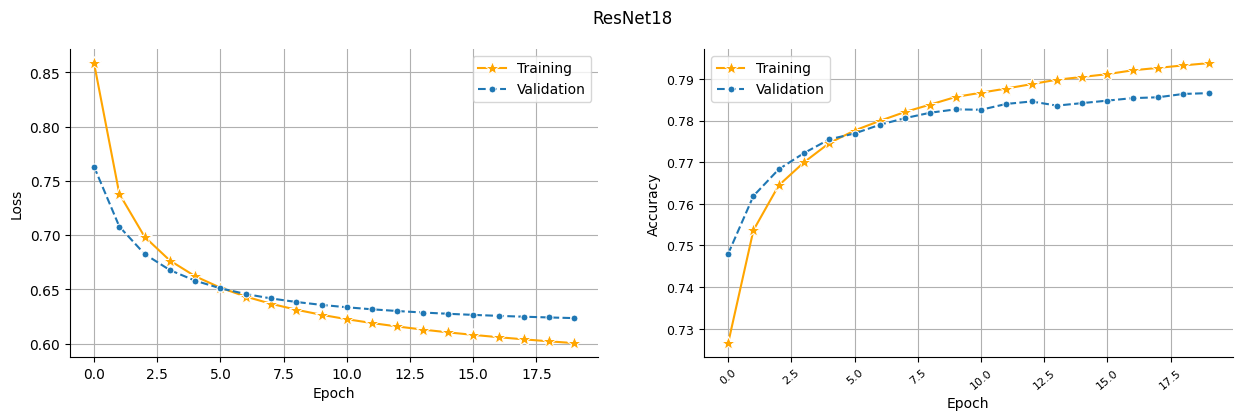

In [ ]:
plot_loss_and_accuracy(experiment, title='ResNet18')

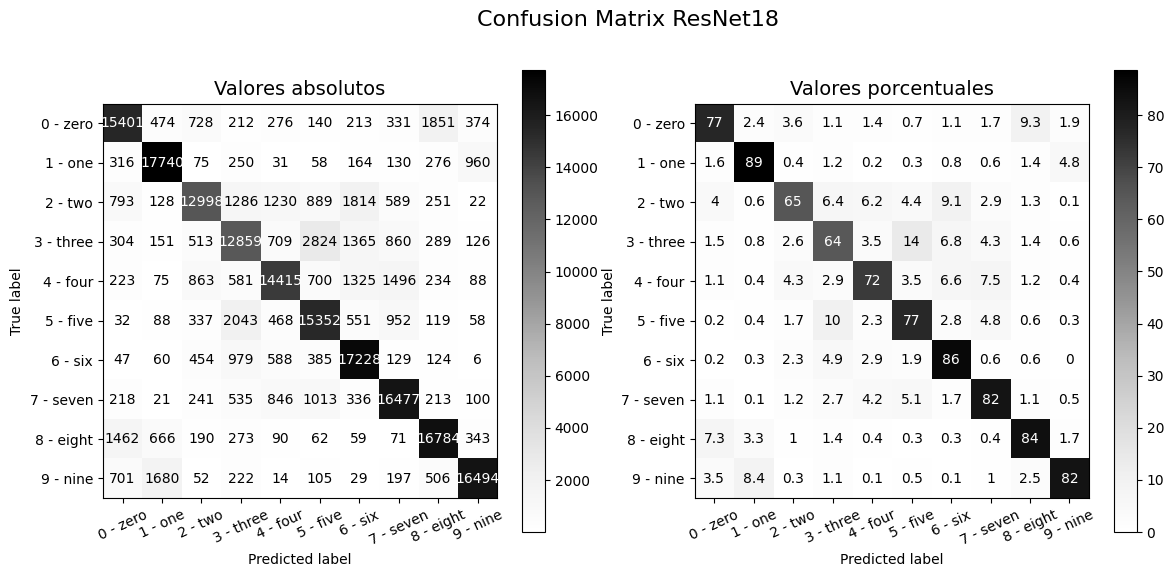

In [ ]:
plotting_confusion_matrix(all_labels, all_preds, title_name='ResNet18')

### Transfer Learning [VGG16](https://pytorch.org/vision/stable/models/generated/torchvision.models.vgg16.html)

Los modelos VGG (Visual Geometry Group) son una familia de redes neuronales convolucionales (CNN) propuestas en 2014 por Karen Simonyan y Andrew Zisserman. Su principal característica es la simplicidad en el diseño: utilizan secuencias de pequeñas convoluciones de 3x3, con capas de pooling para reducir las dimensiones, en lugar de convoluciones más grandes.

**Características claves**
- *Capas profundas*: VGG introduce arquitecturas de 16 y 19 capas, lo que permitió mejorar el rendimiento en tareas de clasificación de imágenes.
- *Filtros pequeños*: usa filtros de 3x3 a lo largo de toda la red, lo que mejora la precisión sin aumentar demasiado la cantidad de parámetros.
- *Pooling*: reduce las dimensiones con capas de max pooling (2x2).
- *Capas totalmente conectadas*: Al final, emplea varias capas densamente conectadas antes de la capa de salida.

**Arquitecturas**
- VGG16: 13 capas convolucionales + 3 capas totalmente conectadas.
- VGG19: 16 capas convolucionales + 3 capas totalmente conectadas.

**Aplicaciones**
Se usa principalmente para clasificación de imágenes y tareas de visión por computadora, como detección de objetos y segmentación.
Aunque *ya no es el estado del arte*, VGG sigue siendo una referencia debido a su simplicidad y efectividad en transfer learning.

In [ ]:
# Exploremos otro modelo pre-entrenado
model_fit_vgg16 = torchvision.models.vgg16(weights='VGG16_Weights.DEFAULT')
model_fit_vgg16

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 90.6MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Veamos el grupos de capas clasificadoras
model_fit_vgg16.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [ ]:
# Veamos la última capa clasificadora
model_fit_vgg16.classifier[6]

Linear(in_features=4096, out_features=1000, bias=True)

In [ ]:
model_tl = model_fit_vgg16
# Modifiquemos algunas capas clasificadoras para reentrenarla con los datos y poder hacer la clasificación de 10 clases
for param in model_tl.parameters():
    param.requires_grad = False

n_clases = 10
model_tl.classifier[3].requires_grad = True
model_tl.classifier[3] = nn.Linear(4096, 1024)
model_tl.classifier[6].requires_grad = True
model_tl.classifier[6] = nn.Linear(1024, n_clases)
model_tl.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=1024, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=1024, out_features=10, bias=True)
)

In [ ]:
# Explorar las capas del modelo
for i, w in enumerate(model_tl.parameters()):
    print(i, w.shape, w.requires_grad)

0 torch.Size([64, 3, 3, 3]) False
1 torch.Size([64]) False
2 torch.Size([64, 64, 3, 3]) False
3 torch.Size([64]) False
4 torch.Size([128, 64, 3, 3]) False
5 torch.Size([128]) False
6 torch.Size([128, 128, 3, 3]) False
7 torch.Size([128]) False
8 torch.Size([256, 128, 3, 3]) False
9 torch.Size([256]) False
10 torch.Size([256, 256, 3, 3]) False
11 torch.Size([256]) False
12 torch.Size([256, 256, 3, 3]) False
13 torch.Size([256]) False
14 torch.Size([512, 256, 3, 3]) False
15 torch.Size([512]) False
16 torch.Size([512, 512, 3, 3]) False
17 torch.Size([512]) False
18 torch.Size([512, 512, 3, 3]) False
19 torch.Size([512]) False
20 torch.Size([512, 512, 3, 3]) False
21 torch.Size([512]) False
22 torch.Size([512, 512, 3, 3]) False
23 torch.Size([512]) False
24 torch.Size([512, 512, 3, 3]) False
25 torch.Size([512]) False
26 torch.Size([4096, 25088]) False
27 torch.Size([4096]) False
28 torch.Size([1024, 4096]) True
29 torch.Size([1024]) True
30 torch.Size([10, 1024]) True
31 torch.Size([10])

In [ ]:
num_epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad,
                                   model_tl.parameters()),
                            lr=1e-4, betas=(0.9, 0.999))

experiment, all_labels, all_preds = train_val(model_tl, criterion, optimizer, train_loader, val_loader, num_epochs)

Epoch 1/10, train loss: 0.6896, train acc: 0.7638, val loss: 0.4804, val acc: 0.8345
Epoch 2/10, train loss: 0.5149, train acc: 0.8194, val loss: 0.4515, val acc: 0.8431
Epoch 3/10, train loss: 0.4815, train acc: 0.8302, val loss: 0.4361, val acc: 0.8506
Epoch 4/10, train loss: 0.4573, train acc: 0.8372, val loss: 0.4174, val acc: 0.8553
Epoch 5/10, train loss: 0.4323, train acc: 0.8486, val loss: 0.4150, val acc: 0.8586
Epoch 6/10, train loss: 0.4189, train acc: 0.8501, val loss: 0.4087, val acc: 0.8553
Epoch 7/10, train loss: 0.4041, train acc: 0.8564, val loss: 0.4009, val acc: 0.8609
Epoch 8/10, train loss: 0.3932, train acc: 0.8603, val loss: 0.3970, val acc: 0.8647
Epoch 9/10, train loss: 0.3786, train acc: 0.8652, val loss: 0.3904, val acc: 0.8651
Epoch 10/10, train loss: 0.3694, train acc: 0.8670, val loss: 0.3829, val acc: 0.8678


0
1


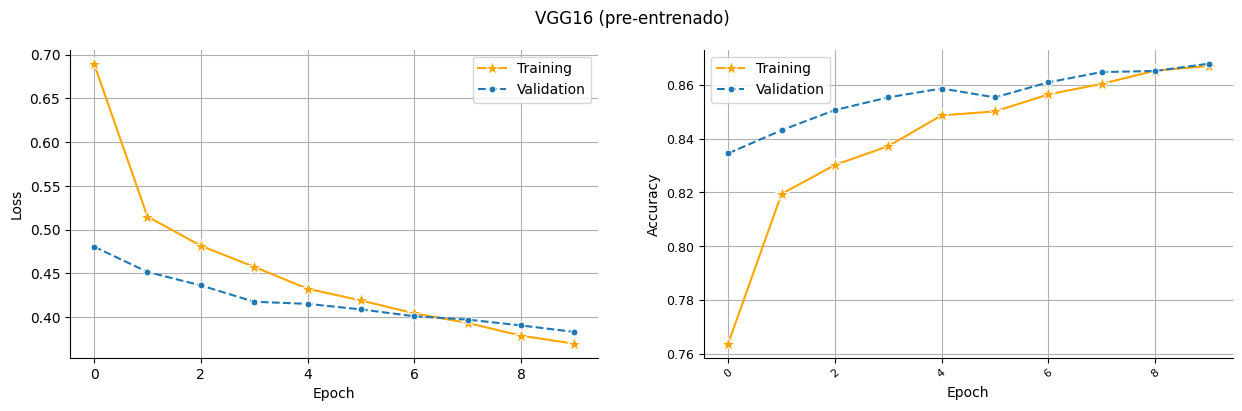

In [ ]:
plot_loss_and_accuracy(experiment, title='VGG16 (pre-entrenado)')

### Transfer Learning [VGG16](https://pytorch.org/vision/stable/models/generated/torchvision.models.vgg16.html) (No preentrenado)

In [ ]:
# Probemos el modelo sin preentrenar
model_tl = torchvision.models.vgg16()
# Congelamos las capas anteriores
for param in model_tl.parameters():
    param.requires_grad = False

# Modificamos algunas capas clasificadoras para reentrenarla con los datos y poder hacer la clasificación de 10 clases
n_clases = 10
model_tl.classifier[3].requires_grad = True
model_tl.classifier[3] = nn.Linear(4096, 1024)
model_tl.classifier[6].requires_grad = True
model_tl.classifier[6] = nn.Linear(1024, n_clases)
print(model_tl.classifier)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
num_epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_tl.parameters(), lr=0.001, momentum=0.9)

experiment, all_labels, all_preds = train_val(model_tl, criterion, optimizer, train_loader, val_loader, num_epochs)

Epoch 1/10, train loss: 2.2899, train acc: 0.1254, val loss: 2.2694, val acc: 0.1706
Epoch 2/10, train loss: 2.2491, train acc: 0.1930, val loss: 2.2082, val acc: 0.2722
Epoch 3/10, train loss: 2.1822, train acc: 0.2283, val loss: 2.1274, val acc: 0.2800
Epoch 4/10, train loss: 2.1167, train acc: 0.2507, val loss: 2.0613, val acc: 0.2892
Epoch 5/10, train loss: 2.0705, train acc: 0.2641, val loss: 2.0141, val acc: 0.2969
Epoch 6/10, train loss: 2.0345, train acc: 0.2739, val loss: 1.9773, val acc: 0.2981
Epoch 7/10, train loss: 2.0095, train acc: 0.2846, val loss: 1.9473, val acc: 0.3138
Epoch 8/10, train loss: 1.9876, train acc: 0.2938, val loss: 1.9226, val acc: 0.3236
Epoch 9/10, train loss: 1.9676, train acc: 0.3019, val loss: 1.8988, val acc: 0.3328
Epoch 10/10, train loss: 1.9503, train acc: 0.3069, val loss: 1.8833, val acc: 0.3415


0
1


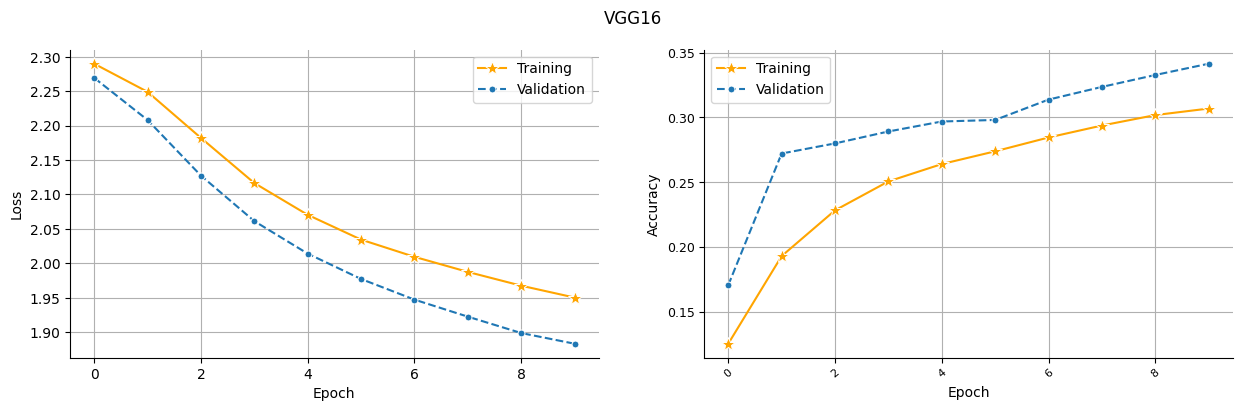

In [ ]:
plot_loss_and_accuracy(experiment, title='VGG16')

### Para jugar con el modelo

In [ ]:
# Cambiar transform de los datos
# Barajar los indices
indices = np.arange(50000)
np.random.shuffle(indices)
n_train = 45000

# Transformar los datos en tensores y normalícelos
transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resize (height x width)
    transforms.ToTensor(),
    # Media y desviación estándar de imagenes image-net
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])

# Preparar el conjunto de entrenamiento y el conjunto de validación
dataset = datasets.CIFAR10('.', download=True, train=True, transform=transform)

# Construir el cargador de entranamiento
train_loader = DataLoader(dataset,
                          batch_size=64,
                          shuffle=True,
                        # shuffle=False, sampler=SubsetRandomSampler(indices[:n_train])
                            )

# Construir el cargador de validación
val_loader = DataLoader(dataset,
                            batch_size=64, shuffle=False,
                            sampler=SubsetRandomSampler(indices[n_train:])
)

Files already downloaded and verified


In [ ]:
# Modifique este grupo de capas de clasificación para reentrenar el modelo con nuestros datos
# Reentrenar la segunda capa lineal
model_tl.classifier[3].requires_grad = True
# Modificar la última y penúltima capa de clasificación para reducir el número de parámetros
model_tl.classifier[6] = nn.Sequential(
                      nn.Linear(4096, 256),
                      nn.ReLU(),
                      nn.Dropout(0.3),
                      nn.Linear(256, n_clases))

In [ ]:
model_tl.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)